In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-airport-dataset/Airports2.csv


# 5. Finding and Extracting Communities (Q5)


Airlines can optimize their operations by identifying communities within a flight network. These communities represent groups of airports with strong connections, helping airlines pinpoint high-demand regions for expansion or underserved areas for consolidation. By analyzing these communities, airlines can improve resource allocation, reduce costs, and enhance service quality.



1. In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.
   
2. The function takes the following inputs:

- Flight network
- A city name *c1*
- A city name *c2*
  
3. The function outputs:

- The total number of communities and the cities that belong to each community
- Visualize the graph highlighting the communities within the network (each community with different color)
- If city c1 and c2 belong to the same community or not

In [ ]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:

# Source: https://www.geeksforgeeks.org/depth-first-search-or-dfs-for-a-graph/
def dfs_rec(adj, visited, node, component):
    """
    Recursive Depth-First Search (DFS) function to explore a connected component in the graph.
    
    This function visits all nodes reachable from the given 'node' and adds them to the same 
    connected component. It uses recursion to traverse all unvisited neighbors.
    """
    visited.add(node)  # Mark the current node as visited
    component.append(node)  # Add the current node to the component
    
    #print(f"Step {step_counter}:")
    #print(f"  Current Node: {node}")
    #print(f"  Visited Nodes: {visited}")
    #print(f"  Current Component: {component}")
    #print("----------------------------------")
    #step_counter += 1

    # Recursively visit all unvisited neighbors
    for neighbor in adj[node]:
        if neighbor not in visited:  # Process only unvisited nodes
            dfs_rec(adj, visited, neighbor, component)

# same source as before
def find_connected_components(adj):
    """
    Finds all connected components in an undirected graph using DFS.

    This function iterates through all nodes in the graph, and whenever an unvisited
    node is encountered, it initiates a DFS to discover a new connected component.

    Args:
        adj (dict): Adjacency list representing the graph.

    Returns:
        list: A list of connected components, where each component is represented 
              as a list of nodes.
    """
    visited = set()  # A set to keep track of visited nodes
    components = []  # A list to store all connected components

    # Iterate through all nodes in the graph
    for node in adj:
        if node not in visited:  # If the node is unvisited, start a new DFS
            component = []  # Initialize a new component
            #print(f"Starting new DFS for component at node {node}:")
            dfs_rec(adj, visited, node, component)  # Explore the component using DFS
            components.append(component)  # Add the discovered component to the list

    return components 

# Source: https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/
def bfs_shortest_paths(graph, source):
    """
    Perform Breadth-First Search (BFS) to calculate the shortest paths from a given source node to all other nodes.
    BFS explores vertices level by level, using a queue data structure. This implementation also tracks the parents 
    of each node to reconstruct shortest paths.
    """
    queue = deque([source]) # Initialize a queue for BFS, starting with the source node

    distances = {node: float('inf') for node in graph} # Set the distance to all nodes as infinity (unvisited)
    distances[source] = 0 # Set the distance to the source node as 0 (starting point).

    # Initialize the parents dictionary:
    # - Tracks all parents for each node along shortest paths.
    parents = defaultdict(list) # parents dict tracks all parents for each node along shortest paths
    
    #step = 0

    while queue: # until all vertices are reachable
        # Dequeue the current node
        current = queue.popleft() # remove from queue

        #print(f"Step {step}:")
        #print(f"  Current Node: {current}")
        #print(f"  Queue: {list(queue)}")
        #print(f"  Distances: {distances}")
        #print(f"  Parents: {dict(parents)}")

        # Explore all adjacent vertices of the current node
        for neighbor in graph[current]:
            if distances[neighbor] == float('inf'): # so not visited
                distances[neighbor] = distances[current] + 1 # update as one level deeper than current node
                queue.append(neighbor) # add to queue to process later

            if distances[neighbor] == distances[current] + 1: # if distance is exactly one level deeper than the current node
                parents[neighbor].append(current) # Add the current node as a parent of the neighbor

    return distances, parents


# Source: https://symbio6.nl/en/blog/analysis/betweenness-centrality (only for the concept)
from collections import defaultdict

def calculate_betweenness(graph):
    """
    Calculate edge betweenness centrality for all edges in an undirected network.

    Betweenness centrality measures the "bridgeness" of an edge by evaluating the fraction
    of shortest paths between all pairs of nodes in the network that pass through that edge.
    """

    betweenness = defaultdict(int) # Dict to store BC values for edges

    for node in graph:
        #print(f"\nProcessing Source Node: {node}")
        distances, parents = bfs_shortest_paths(graph, node) # BFS return shortest paths and their parent relationships
        #print(f"  BFS Distances from {node}: {distances}")
        #print(f"  BFS Parents from {node}: {dict(parents)}")
        node_flow = {n: 1 for n in graph} # Initialize flow for all nodes as 1 (default contribution to shortest paths)

        nodes_by_distance = sorted(distances, key=distances.get, reverse=True) # Process nodes with farthest nodes first
        #print(f"  Nodes by Distance (Reverse): {nodes_by_distance}")

        # Backtrack from farthest nodes to distribute flow across edges
        for target in nodes_by_distance: 
            for parent in parents[target]:
                # Define the edge between parent and target
                edge = tuple(sorted((parent, target)))  # Define edge between parent and target. Sort to avoid duplicates
                
                # Distribute flow proportionally across all shortest paths to the target
                flow = node_flow[target] / len(parents[target])  # Split flow equally
                betweenness[edge] += flow  # Add flow to the edge's betweenness
                node_flow[parent] += flow  # Pass flow back to the parent node
                #print(f"    Updated Betweenness for Edge {edge}: {betweenness[edge]}")
                #print(f"    Flow Distribution: Node {parent} Flow: {node_flow[parent]}")
                
    #for edge, score in betweenness.items():
        #print(f"  Edge {edge}: {score}")

    return betweenness

# Source: https://memgraph.github.io/networkx-guide/algorithms/community-detection/girvan-newman/
def girvan_newman(graph):
    """
    Implementation of the Girvan-Newman algorithm for community detection in networks.

    The Girvan-Newman algorithm iteratively removes edges with the highest edge betweenness centrality, 
    progressively breaking the graph into smaller connected components (communities).
    The algorithm stops when all edges have been removed or when the desired number of communities is reached.
    """

    graph_copy = {k: set(v) for k, v in graph.items()} # copy of the graph to avoid modifying the original graph

    communities = []
    iteration = 0  # For debugging

    while len(graph_copy) > 0: # continue until the graph is empty
        betweenness = calculate_betweenness(graph_copy)
        if not betweenness:  # If no edges remain, stop
            break

        edge_to_remove = max(betweenness, key=betweenness.get)  # Find edge with max centrality
        graph_copy[edge_to_remove[0]].remove(edge_to_remove[1])  # Remove edge from both nodes
        graph_copy[edge_to_remove[1]].remove(edge_to_remove[0])  # Remove edge from both nodes

        communities = find_connected_components(graph_copy) # Recalculate the communities after removing the edge

        # Debug
        print(f"[DEBUG] Iteration {iteration}: Removed edge {edge_to_remove}")
        print(f"[DEBUG] Current number of communities: {len(communities)}")
        
        iteration += 1 

    # Final debug 
    print("\n[FINAL DEBUG] Total iterations: {iteration}")
    print(f"[FINAL DEBUG] Final number of communities: {len(communities)}")

    return communities


# Visualization
def visualize_communities(graph, communities):
    # Create a NetworkX graph from the adjacency list
    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Assign a unique color to each community
    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = i  # Assign the community index as the color

    # Generate node colors
    node_colors = [color_map.get(node, -1) for node in G.nodes]

    # Plot
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        cmap=plt.cm.rainbow,
        node_size=500,
        font_size=10,
    )
    plt.title("Communities in the Graph")
    plt.show()

To make everything more clear I used a really simple dataset to explain the step by step process of how our algorithm works. (debug prints are then removed from output but left for debugging).
I found this the easier way to explain the thinking process of the algorithm.

In [66]:
explanation_graph = {
    "JFK": ["LAX", "ORD"],
    "LAX": ["JFK", "DFW", "ATL"],
    "ORD": ["JFK", "ATL"],
    "DFW": ["LAX", "ATL"],
    "ATL": ["LAX", "ORD", "DFW"]
}

In [67]:
# HOW DFS WORKS?
step_counter = 0
components = find_connected_components(explanation_graph)
print("\nFinal Connected Components:", components)

Starting new DFS for component at node JFK:
Step 0:
  Current Node: JFK
  Visited Nodes: {'JFK'}
  Current Component: ['JFK']
----------------------------------
Step 1:
  Current Node: LAX
  Visited Nodes: {'JFK', 'LAX'}
  Current Component: ['JFK', 'LAX']
----------------------------------
Step 2:
  Current Node: DFW
  Visited Nodes: {'DFW', 'JFK', 'LAX'}
  Current Component: ['JFK', 'LAX', 'DFW']
----------------------------------
Step 3:
  Current Node: ATL
  Visited Nodes: {'DFW', 'JFK', 'ATL', 'LAX'}
  Current Component: ['JFK', 'LAX', 'DFW', 'ATL']
----------------------------------
Step 4:
  Current Node: ORD
  Visited Nodes: {'JFK', 'ORD', 'LAX', 'ATL', 'DFW'}
  Current Component: ['JFK', 'LAX', 'DFW', 'ATL', 'ORD']
----------------------------------

Final Connected Components: [['JFK', 'LAX', 'DFW', 'ATL', 'ORD']]


In [74]:
# HOW DOES BFS WORKS?
source = 'JFK'
bfs_shortest_paths(explanation_graph, source)

Step 0:
  Current Node: JFK
  Queue: []
  Distances: {'JFK': 0, 'LAX': inf, 'ORD': inf, 'DFW': inf, 'ATL': inf}
  Parents: {}
Step 0:
  Current Node: LAX
  Queue: ['ORD']
  Distances: {'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': inf, 'ATL': inf}
  Parents: {'LAX': ['JFK'], 'ORD': ['JFK']}
Step 0:
  Current Node: ORD
  Queue: ['DFW', 'ATL']
  Distances: {'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': 2, 'ATL': 2}
  Parents: {'LAX': ['JFK'], 'ORD': ['JFK'], 'DFW': ['LAX'], 'ATL': ['LAX']}
Step 0:
  Current Node: DFW
  Queue: ['ATL']
  Distances: {'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': 2, 'ATL': 2}
  Parents: {'LAX': ['JFK'], 'ORD': ['JFK'], 'DFW': ['LAX'], 'ATL': ['LAX', 'ORD']}
Step 0:
  Current Node: ATL
  Queue: []
  Distances: {'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': 2, 'ATL': 2}
  Parents: {'LAX': ['JFK'], 'ORD': ['JFK'], 'DFW': ['LAX'], 'ATL': ['LAX', 'ORD']}


({'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': 2, 'ATL': 2},
 defaultdict(list,
             {'LAX': ['JFK'],
              'ORD': ['JFK'],
              'DFW': ['LAX'],
              'ATL': ['LAX', 'ORD']}))

In [77]:
# Example of how betweenness is calculated
betweenness = calculate_betweenness(explanation_graph)


Processing Source Node: JFK
  BFS Distances from JFK: {'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': 2, 'ATL': 2}
  BFS Parents from JFK: {'LAX': ['JFK'], 'ORD': ['JFK'], 'DFW': ['LAX'], 'ATL': ['LAX', 'ORD']}
  Nodes by Distance (Reverse): ['DFW', 'ATL', 'LAX', 'ORD', 'JFK']
    Updated Betweenness for Edge ('DFW', 'LAX'): 1.0
    Flow Distribution: Node LAX Flow: 2.0
    Updated Betweenness for Edge ('ATL', 'LAX'): 0.5
    Flow Distribution: Node LAX Flow: 2.5
    Updated Betweenness for Edge ('ATL', 'ORD'): 0.5
    Flow Distribution: Node ORD Flow: 1.5
    Updated Betweenness for Edge ('JFK', 'LAX'): 2.5
    Flow Distribution: Node JFK Flow: 3.5
    Updated Betweenness for Edge ('JFK', 'ORD'): 1.5
    Flow Distribution: Node JFK Flow: 5.0

Processing Source Node: LAX
  BFS Distances from LAX: {'JFK': 1, 'LAX': 0, 'ORD': 2, 'DFW': 1, 'ATL': 1}
  BFS Parents from LAX: {'JFK': ['LAX'], 'DFW': ['LAX'], 'ATL': ['LAX'], 'ORD': ['JFK', 'ATL']}
  Nodes by Distance (Reverse): ['ORD', 'JFK', 'DFW', '

In [78]:
# Putting everything together
ex_communities = girvan_newman(explanation_graph)
print(f"Final Detected Communities: {len(ex_communities)}")


Processing Source Node: JFK
  BFS Distances from JFK: {'JFK': 0, 'LAX': 1, 'ORD': 1, 'DFW': 2, 'ATL': 2}
  BFS Parents from JFK: {'LAX': ['JFK'], 'ORD': ['JFK'], 'DFW': ['LAX'], 'ATL': ['LAX', 'ORD']}
  Nodes by Distance (Reverse): ['DFW', 'ATL', 'LAX', 'ORD', 'JFK']
    Updated Betweenness for Edge ('DFW', 'LAX'): 1.0
    Flow Distribution: Node LAX Flow: 2.0
    Updated Betweenness for Edge ('ATL', 'LAX'): 0.5
    Flow Distribution: Node LAX Flow: 2.5
    Updated Betweenness for Edge ('ATL', 'ORD'): 0.5
    Flow Distribution: Node ORD Flow: 1.5
    Updated Betweenness for Edge ('JFK', 'LAX'): 2.5
    Flow Distribution: Node JFK Flow: 3.5
    Updated Betweenness for Edge ('JFK', 'ORD'): 1.5
    Flow Distribution: Node JFK Flow: 5.0

Processing Source Node: LAX
  BFS Distances from LAX: {'JFK': 1, 'LAX': 0, 'ORD': 2, 'DFW': 1, 'ATL': 1}
  BFS Parents from LAX: {'DFW': ['LAX'], 'JFK': ['LAX'], 'ATL': ['LAX'], 'ORD': ['JFK', 'ATL']}
  Nodes by Distance (Reverse): ['ORD', 'JFK', 'DFW', '

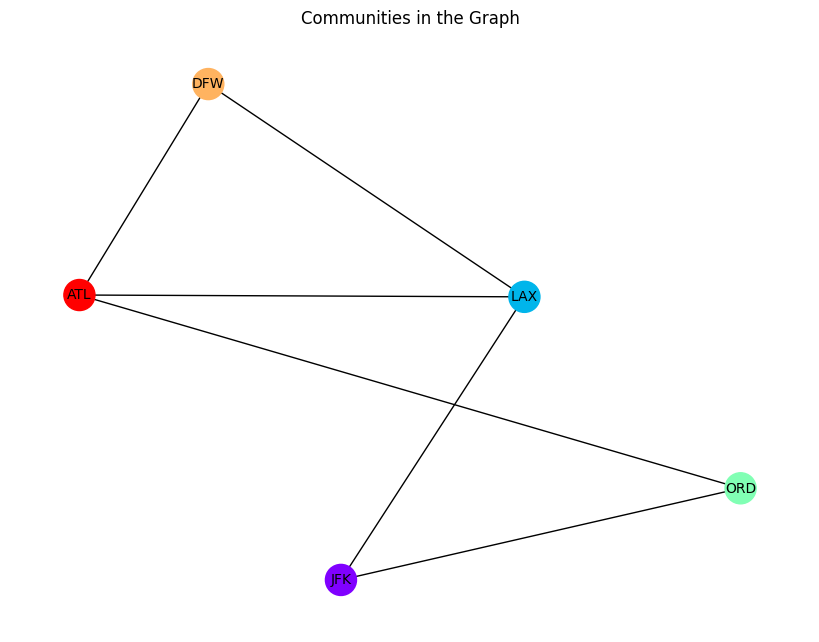

In [82]:
visualize_communities(explanation_graph, ex_communities)
